### Welcome! In this lab session, you will familiarize yourself with regression analysis. We will learn how to do descriptive regression analysis in python. We will use the statsmodels library. After an introductory tutorial, you will work on solving an exercise that we prepared for you.

### References:
- More information on formula syntax: https://patsy.readthedocs.io/en/latest/formulas.html
- More information on statsmodels: https://www.statsmodels.org/dev/example_formulas.html

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math
from statsmodels.stats import diagnostic
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [3]:
data_folder = './data/'
df = pd.read_csv(data_folder + 'heart_failure_clinical_records_dataset.csv')

## Statsmodels tutorial

We will use a dataset with information about patients with cardiovascular diseases. Here is the breakdown of columns:

Some variables are categorical:
- 'DEATH_EVENT': if the patient deceased during the follow-up period
- 'sex': male/female (binary, male 1, female 0)
- 'anaemia': decrease of red blood cells (boolean, yes 1)
- 'smoking': if the patient smokes or not (boolean, yes 1)
- 'diabetes': if the patient has diabetes (boolean, yes 1)
- 'high_blood_pressure': if the person has hypertension (boolean, yes 1)


... and some are continuous/discrete:
- 'age': patient's age
- 'creatinine_phosphokinase': level of CPK enzyme in the blood (mcg/L)
- 'ejection_fraction': percentage of blood leaving the heart in each contraction
- 'platelets': platelets in the blood (kiloplatelets/mL)
- 'serum_creatinine': level of serum creatinine in the blood (mg/dL)
- 'serum_sodium': level of serum sodium in the blood (mEq/L)
- 'time': duration of the follow-up period (number of days in the hospital)


In [4]:
df.sample(10)

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
64,45.000,0,582,0,80,0,263358.03,1.18,137,0,0,63,0
88,44.000,0,84,1,40,1,235000.00,0.70,139,1,0,79,0
172,70.000,1,171,0,60,1,176000.00,1.10,145,1,1,146,0
280,70.000,0,2695,1,40,0,241000.00,1.00,137,1,0,247,0
185,60.667,1,104,1,30,0,389000.00,1.50,136,1,0,171,1
136,65.000,1,59,1,60,0,172000.00,0.90,137,0,0,107,0
74,69.000,0,582,0,20,0,266000.00,1.20,134,1,1,73,1
39,60.000,0,235,1,38,0,329000.00,3.00,142,0,0,30,1
221,65.000,0,118,0,50,0,194000.00,1.10,145,1,1,200,0
0,75.000,0,582,0,20,1,265000.00,1.90,130,1,0,4,1


In [5]:
# 299 patients
len(df)

299

## Part 1 Linear regression: Modelling time spent at the hospital

- We will perform a regression analysis to model the number of days spent at the hospital, among the population of patients.


- To get started with our model, we need two components:

   1. The equation describing the model
   2. The data
   
   
- Equations are specified using patsy formula syntax. Important operators are:
    1. `~` : Separates the left-hand side and right-hand side of a formula.
    2. `+` : Creates a union of terms that are included in the model.
    3. `:` : Interaction term.
    3. `*` : `a * b` is short-hand for `a + b + a:b`, and is useful for the common case of wanting to include all interactions between a set of variables.
    
    
- Intercepts are added by default.


- Categorical variables can be included directly by adding a term C(a). More on that soon!


- For (2), we can conveniently use pandas dataframe.

### An example

- Let's start with an example from our dataset. We are interested in two predictors: diabetes and high blood pressure. These are the two predictors that we want to use to fit the outcome, the number of days spent at the hospital, using a linear regression.

- A model that achieves this is formulated as:
        time ~ C(diabetes) + C(high_blood_pressure)
        
- We can create this model using smf.ols().

- OLS stands for ordinary least squares linear regression.

- The two components: the formula and the data are stated explicitly.

- The terms in the formula are columns in pandas dataframe. Easy!

In [6]:
# Declares the model
mod = smf.ols(formula='time ~ C(diabetes) + C(high_blood_pressure)', data=df)

In [7]:
# Fits the model (find the optimal coefficients, adding a random seed ensures consistency)
np.random.seed(2)
res = mod.fit()

In [8]:
# Print thes summary output provided by the library.
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   time   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     6.097
Date:                Fri, 21 Oct 2022   Prob (F-statistic):            0.00254
Time:                        20:41:20   Log-Likelihood:                -1718.9
No. Observations:                 299   AIC:                             3444.
Df Residuals:                     296   BIC:                             3455.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

### A lot of useful information is provided by default.

- The dependent variable : time (number of days at the hospital)
- Method: The type of model that was fitted (OLS)
- Nb observations: The number of datapoints (299 patients)
- R2: The fraction of explained variance
- A list of predictors
- For each predictor: coefficient, standard error of the coefficients, p-value, 95% confidence intervals. We can see that only high blood pressure is a significant predictor (p = 0.001), while diabetes is not (0.584).
- Warnings if there are numerical issues (hopefully not!)

### Now, we can interpret the model that we just fitted.

- Notice how C(diabetes)[T.1] is created based on the original diabetes feature. This means that the dummy variable is encoded such that the associated coefficient tells us about the value among the diabetes = yes subpopulation.


- We interpret the model in the following way: days at hospital = 139 + 4.9 * diabetes - 31.8 * high blood pressure. Thus:
    1. People who don't have diabetes nor high blood pressure stay at the hospital on average for 139 days
    2. People who have diabetes, but don't have blood pressure stay for 139 + 4.9 days ~ 144 days
    3. People who don't have diabetes, but have blood pressure stay for 139 - 31 days ~ 108 days
    4. People who have diabetes and blood pressure stay for 139 + 4.9 - 31.8 ~ 112 days
    
- We calculate the means explicitly to make sure they are the same as what we just calculated with regression!

In [9]:
print(df.loc[(df['diabetes'] == 0) & (df["high_blood_pressure"] == 0)]['time'].mean())
print(df.loc[(df['diabetes'] == 1) & (df["high_blood_pressure"] == 0)]['time'].mean())
print(df.loc[(df['diabetes'] == 0) & (df["high_blood_pressure"] == 1)]['time'].mean())
print(df.loc[(df['diabetes'] == 1) & (df["high_blood_pressure"] == 1)]['time'].mean())

139.0
144.8170731707317
108.25806451612904
111.46511627906976


- Isn't it strange that high blood pressure has a negative coefficient? It seems like the patients who have high blood pressure stay at the hospital for shorter number of days, even though one would expect the opposite. Lets' get to that!

## Part 2 Linear regression with interaction terms: Modelling time spent at the hospital V2

- One reason why serious conditions can be associated with lower time spent at the hospital is because of a third confounding factor: death 💀. Patients who have a serious condition might spend less time at the hospital because they die.

- Let's get a better sense of what is happening by modeling the time spent at the hospital with death as a predictor.

- This time we will add interaction features.

In [10]:
# we use a*b to add terms: a, b, a:b, and intercept

mod = smf.ols(formula='time ~ C(high_blood_pressure) * C(DEATH_EVENT,  Treatment(reference=0)) + C(diabetes)',
              data=df)


res = mod.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   time   R-squared:                       0.303
Model:                            OLS   Adj. R-squared:                  0.293
Method:                 Least Squares   F-statistic:                     31.92
Date:                Fri, 21 Oct 2022   Prob (F-statistic):           4.32e-22
Time:                        20:49:05   Log-Likelihood:                -1671.0
No. Observations:                 299   AIC:                             3352.
Df Residuals:                     294   BIC:                             3371.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                                                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

### Interpretation:

- This model lets us see that death is associated with a lower number of days spent at the hospital.
- Notice how R2 is much larger compared to the previous model: more variance in the data is explained.
- Those that have high blood pressure stay for less time (-26 days on average), those who have blood pressure __and__ die spend 2.7 days more hospitalized on average, although this is not statistically significant.

## Part 3 Logistic regression: Modelling the binary death outcome

- Finally, let's model the binary outcome of death, based on all patients' features.
- We will exclude time spent at the hospital, since we saw how it is strongly correlated with death.

### First, we will do standardization of continuous predictors. This will let us interpret the predictors that are of vastly different scales (from percents to thousands).

In [11]:
# how we standardize the countinuous variables

df['age'] = (df['age'] - df['age'].mean())/df['age'].std()
df['creatinine_phosphokinase'] = (df['creatinine_phosphokinase'] - df['creatinine_phosphokinase'].mean())/df['creatinine_phosphokinase'].std()
df['ejection_fraction'] = (df['ejection_fraction'] - df['ejection_fraction'].mean())/df['ejection_fraction'].std()
df['platelets'] = (df['platelets'] - df['platelets'].mean())/df['platelets'].std()
df['serum_creatinine'] = (df['serum_creatinine'] - df['serum_creatinine'].mean())/df['serum_creatinine'].std()
df['serum_sodium'] = (df['serum_sodium'] - df['serum_sodium'].mean())/df['serum_sodium'].std()

### Instead of linear, we will now use a logistic regression to model the binary outcome.

In [12]:
# logit is logistic regression. The other parameters are the same as before

mod = smf.logit(formula='DEATH_EVENT ~  age + creatinine_phosphokinase + ejection_fraction + \
                        platelets + serum_creatinine + serum_sodium + \
                        C(diabetes) + C(high_blood_pressure) +\
                        C(sex) + C(anaemia) + C(smoking) + C(high_blood_pressure)', data=df)
res = mod.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.492108
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:            DEATH_EVENT   No. Observations:                  299
Model:                          Logit   Df Residuals:                      287
Method:                           MLE   Df Model:                           11
Date:                Fri, 21 Oct 2022   Pseudo R-squ.:                  0.2160
Time:                        20:54:15   Log-Likelihood:                -147.14
converged:                       True   LL-Null:                       -187.67
Covariance Type:            nonrobust   LLR p-value:                 9.169e-13
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      -1.1633      0.362     -3.214      0.001   

#### Looks good! We have a reasonably high R2 (0.216). In addition to reading the coefficients from the summary table, let's access them programmatically from the res object.

In [15]:
# feature names
variables = res.params.index
print(variables)
# quantifying uncertainty!

# coefficients
coefficients = res.params.values
print(coefficients)
# p-values
p_values = res.pvalues
print(p_values)
# standard errors
standard_errors = res.bse.values
print(standard_errors)
#confidence intervals
res.conf_int()

Index(['Intercept', 'C(diabetes)[T.1]', 'C(high_blood_pressure)[T.1]',
       'C(sex)[T.1]', 'C(anaemia)[T.1]', 'C(smoking)[T.1]', 'age',
       'creatinine_phosphokinase', 'ejection_fraction', 'platelets',
       'serum_creatinine', 'serum_sodium'],
      dtype='object')
[-1.16325131  0.15140764  0.41893769 -0.39901405  0.41792976  0.13558917
  0.66243288  0.28190843 -0.83225    -0.06937879  0.68470142 -0.25004061]
Intercept                      0.001310
C(diabetes)[T.1]               0.610644
C(high_blood_pressure)[T.1]    0.171092
C(sex)[T.1]                    0.255394
C(anaemia)[T.1]                0.164904
C(smoking)[T.1]                0.697300
age                            0.000022
creatinine_phosphokinase       0.041907
ejection_fraction              0.000002
platelets                      0.660857
serum_creatinine               0.000135
serum_sodium                   0.089558
dtype: float64
[0.36196181 0.29737051 0.30608386 0.35082968 0.30093579 0.34858686
 0.15621543 0.1385

,0,1
Intercept,-1.872683,-0.453819
C(diabetes)[T.1],-0.431428,0.734243
C(high_blood_pressure)[T.1],-0.180976,1.018851
C(sex)[T.1],-1.086628,0.288599
C(anaemia)[T.1],-0.171894,1.007753
C(smoking)[T.1],-0.547629,0.818807
age,0.356256,0.968609
creatinine_phosphokinase,0.010320,0.553497
ejection_fraction,-1.177018,-0.487482
platelets,-0.379319,0.240561


### Now we can visualize the effect of all the predictors. Let's first sort them by the coefficients.

In [16]:
# sort them all by coefficients
l1, l2, l3, l4 = zip(*sorted(zip(coefficients[1:], variables[1:], standard_errors[1:], p_values[1:])))

# in this case, we index starting from the first element, not to plot the intercept

# we will use standard errors, instead of CIs
# two standard errors approximate the CIs (you can actually see in the summary table that
# +/2 SI is equivalent to the CIs)

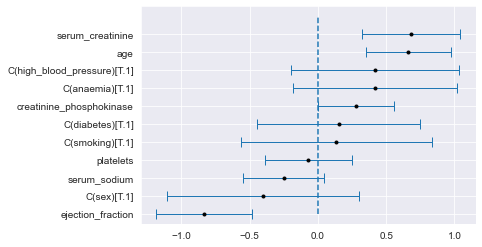

In [17]:
# fancy plotting

plt.errorbar(l1, np.array(range(len(l1))), xerr= 2*np.array(l3), linewidth = 1,
             linestyle = 'none',marker = 'o',markersize= 3,
             markerfacecolor = 'black',markeredgecolor = 'black', capsize= 5)

plt.vlines(0,0, len(l1), linestyle = '--')

plt.yticks(range(len(l2)),l2);

### Interpretation:
- Serum creatinine level in the blood and age are significant positive predictors of death.
- High ejection fraction (a healthy heart) is a sigificant negative predictor of death.
- Since all predictors are standardized, we can interpret in the following way:
    - When all other predictors take mean values, an increase of age by 1 standard deviation, leads on average to an increase by 0.66 of log odds of death.
    - When all other predictors take mean values, increase of ejection fraction by 1 standard deviation, leads on average to a  decrease by 0.83 of log odds of death.

### Interpreting log odds

- Why log odds? remember that that's what logistic regression models.
    - Notice that log odds are a bit difficult to interpret.
    - If an event has probability p, it has odds 1/(1-p).
    - This is a non-linear transformation over p. See the plot below!

Text(0, 0.5, 'log odds')

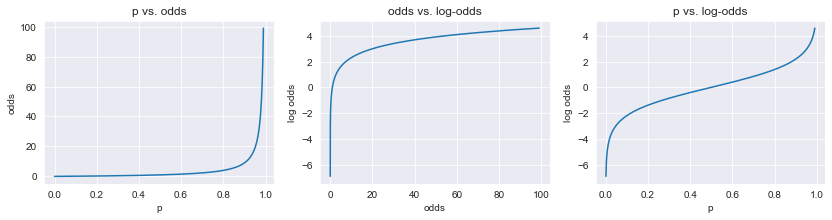

In [18]:
np.seterr(divide = 'ignore') 
fig, axs = plt.subplots(1, 3, figsize=(14,3))
p = np.linspace(0, 0.99, 1000)
odds = p/(1-p)
axs[0].set_title("p vs. odds")
axs[0].plot(p, odds)
axs[0].set_xlabel("p")
axs[0].set_ylabel("odds")

axs[1].set_title("odds vs. log-odds")
axs[1].plot(odds, np.log(odds))
axs[1].set_xlabel("odds")
axs[1].set_ylabel("log odds")

axs[2].set_title("p vs. log-odds")
axs[2].plot(p, np.log(odds))
axs[2].set_xlabel("p")
axs[2].set_ylabel("log odds")

With this in mind, calculate:

1. If p = 0.1 and you have a change in log odds equals to +0.66, what will be your new p?

1. If p = 0.9 and you have a change in log odds equals to +0.66, what will be your new p?

In [19]:
"""Your code here"""
def p_to_log_odds(p):
    return np.log(p/(1-p))
def log_odds_to_p(odds):
    return np.exp(odds) / (1+ np.exp(odds))

In [20]:
odds = p_to_log_odds(0.1)
log_odds_to_p(odds + 0.66)

0.17693910183506342

In [21]:
odds = p_to_log_odds(0.9)
log_odds_to_p(odds + 0.66)

0.9456909311361745

### Controlling for variables

Notice that independent variables (those used as features of our regression model) are often correlated!

For instance serum creatinine, a blood measurement, is an important indicator of kidney health. 
We may want to study its impact in patients' outcomes (in this case, death).

1. Using a logistic regression model, estimate the effect of serum creatinine to a patient's health.

In [25]:
"""Your code here"""
mod = smf.logit(formula="DEATH_EVENT ~ serum_creatinine", data=df)

res = mod.fit()

print(res.summary())

Optimization terminated successfully.
         Current function value: 0.580689
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:            DEATH_EVENT   No. Observations:                  299
Model:                          Logit   Df Residuals:                      297
Method:                           MLE   Df Model:                            1
Date:                Fri, 21 Oct 2022   Pseudo R-squ.:                 0.07485
Time:                        21:19:33   Log-Likelihood:                -173.63
converged:                       True   LL-Null:                       -187.67
Covariance Type:            nonrobust   LLR p-value:                 1.154e-07
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.7429      0.131     -5.683      0.000      -0.999      -0.487
serum_creat

2. Notice that serum creatinine is significantly correlated with age, that is, the older you are, the highest your value for serum creatinine will be (which is bad!). With this in mind, repeat the logistic regression now using serum creatinine _and_ age as predictor variables. What do you think will happen to the coefficient of serum-creatinine? Decrease or increase?

In [18]:
import scipy.stats as stats
stats.pearsonr(df["age"].values, df["serum_creatinine"])

(0.1591871332835501, 0.0058034329412028325)

In [26]:
"""Your code here"""
mod = smf.logit(formula='DEATH_EVENT ~  serum_creatinine + age', data=df)
res = mod.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.558734
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:            DEATH_EVENT   No. Observations:                  299
Model:                          Logit   Df Residuals:                      296
Method:                           MLE   Df Model:                            2
Date:                Fri, 21 Oct 2022   Pseudo R-squ.:                  0.1098
Time:                        21:21:24   Log-Likelihood:                -167.06
converged:                       True   LL-Null:                       -187.67
Covariance Type:            nonrobust   LLR p-value:                 1.117e-09
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.7976      0.136     -5.880      0.000      -1.063      -0.532
serum_creat

Comment: Notice that the model R-squ. increased! And that the effect of serum_creatinine decreased from ~0.85 to ~0.73! One way to think about this is that since the two are correlated, serum creatinine was also working as a proxy for age, but when we add age explicitly, this proxy effect disappears!
R-squ 增加 被解释的Variance 增大    serum_creatinine的系数变低说明 serum_creatinine 正在代理一部分age的权重

### Log-transformations


Remember from class that a log transform in the dependent variable (y) makes the model multiplicative.

1. Fit a linear model to predict the time spent in the hospital (`time`) as a function of variables `high_blood_pressure`, `diabetes` and `DEATH_EVENT`.

2. Now perform a log transform in the variable `time`, that is, create another column in the dataframe containing the `log` of time. Repeat the model, now using the log of time as the dependent variable.

3. Calculate what is the _additive_ effect of having `high_blood_pressure` in the time spent in the hospital in the first model, and what is the _multiplicative_ effect of having `high_blood_pressure` in the second.

In [27]:
# reload the data to undo the std transforms
data_folder = './data/'
df = pd.read_csv(data_folder + 'heart_failure_clinical_records_dataset.csv')

In [29]:
"""Your code here"""
mod = smf.ols(formula="time ~ C(high_blood_pressure) + C(diabetes) + C(DEATH_EVENT)", data=df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   time   R-squared:                       0.303
Model:                            OLS   Adj. R-squared:                  0.296
Method:                 Least Squares   F-statistic:                     42.69
Date:                Fri, 21 Oct 2022   Prob (F-statistic):           6.12e-23
Time:                        21:25:50   Log-Likelihood:                -1671.0
No. Observations:                 299   AIC:                             3350.
Df Residuals:                     295   BIC:                             3365.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

In [30]:
df["logtime"] = np.log(df["time"])
mod = smf.ols(formula='logtime ~  high_blood_pressure + diabetes + DEATH_EVENT', data=df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                logtime   R-squared:                       0.359
Model:                            OLS   Adj. R-squared:                  0.352
Method:                 Least Squares   F-statistic:                     55.05
Date:                Fri, 21 Oct 2022   Prob (F-statistic):           2.75e-28
Time:                        21:26:17   Log-Likelihood:                -325.52
No. Observations:                 299   AIC:                             659.0
Df Residuals:                     295   BIC:                             673.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               4.9891    

**Comment:** In the first model, `high_blood_pressure` is associated with an additive coefficient of around -25. Thus, in the model, whenever a patient has high blood pressure we deduce -25 days out of the prediction.
In the second model, `high_blood_pressure` is associated with an multiplicative coefficient of around -0.22. This means that, in the model, whenever a patient has high blood pressure we multiply his or her outcome by $e^{-0.22} \simeq 0.80$.